### Obtaining GPCC Data in NETCDF format and using XArray, Dask for analysis

In [5]:
import dask
import dask.array as da
import dask.dataframe as dd
import xarray as xr
import rioxarray as rx
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import cftime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

##### Change working directory

In [2]:
import os
work_dir = '/home/jovyan/PlanetaryComputerExamples/hydroclim'
os.chdir(work_dir)
os.getcwd()

'/home/jovyan/PlanetaryComputerExamples/hydroclim'

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

#### File path to data 

In [15]:
netcdf_path = './data/netcdf/full_data_monthly_v2022_2011_2020_025.nc'
monthly_mean_path = './data/netcdf/precip.mon.ltm.0.25x0.25.v2020.nc'
geojson_path = './data/geojson/kerala_boundary.geojson'
districts_path = './data/geojson/kerala_districts.geojson'

#### Open the NetCDF file using rioxarray

In [7]:
# Open the NetCDF file using rioxarray
riods = rx.open_rasterio(netcdf_path,masked=True, chunks={'time': 'auto'})
mean_riods = rx.open_rasterio(monthly_mean_path,masked=True)
# Define the WGS84 CRS
wgs84_crs = "+proj=longlat +datum=WGS84 +no_defs"

In [ ]:
mean_riods[1] = mean_riods[1].rio.write_crs(wgs84_crs, inplace=True)
mean_riods[1].rio.crs

In [19]:
riods = riods.rio.write_crs(wgs84_crs,inplace=True)riods = riods.rio.write_crs(wgs84_crs,inplace=True)
riods.rio.crs

#### Read GeoJson and Clip data to study Area

In [16]:
gdf = gpd.read_file(geojson_path)
district_gdf = gpd.read_file(districts_path)
geometry = shape(gdf.geometry.iloc[0])

In [ ]:
# Clip the rioxarray dataset using the mask
clipped_riods = riods.rio.clip([geometry], drop =True, crs=wgs84_crs)
# save the result to a new file
clipped_riods.to_netcdf('kerala_monthly_2011_2020.nc')

In [24]:
gdf = gpd.read_file(geojson_path)
geometry = shape(gdf.geometry.iloc[0])
# Clip the rioxarray dataset using the mask
mean_clipped_riods = mean_riods[1].rio.clip([geometry], drop =True, crs=wgs84_crs)
# save the result to a new file
mean_clipped_riods.to_netcdf('kerala_monthly_mean.nc')

##### Open the NetCDF file using rioxarray

In [3]:
nc_file_kerala = './data/netcdf/kerala_monthly_2011_2020.nc'
kerala_mean_file = './data/netcdf/kerala_monthly_mean.nc'

In [6]:
kerala_riods = rx.open_rasterio(nc_file_kerala,masked=True, chunks={'time': 'auto'})
kerala_mean_riods = rx.open_rasterio(kerala_mean_file,masked=True, chunks={'time': 'auto'})

#### Filter Monsoon data

In [7]:
# Filter the dataset to include only months 6, 7, 8 and 9
filtered_riods_2018 = kerala_riods.sel(time=kerala_riods['time'].dt.year.isin([2018]))
filtered_monsoon_riods = filtered_riods_2018.sel(time=filtered_riods_2018['time'].dt.month.isin([6,7,8,9]))
kerala_monsoon_precip = filtered_monsoon_riods['precip'].sum(dim='time', skipna=True)

#### Plot Monsoon Rainfall data

/tmp/ipykernel_1945/1082544190.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):


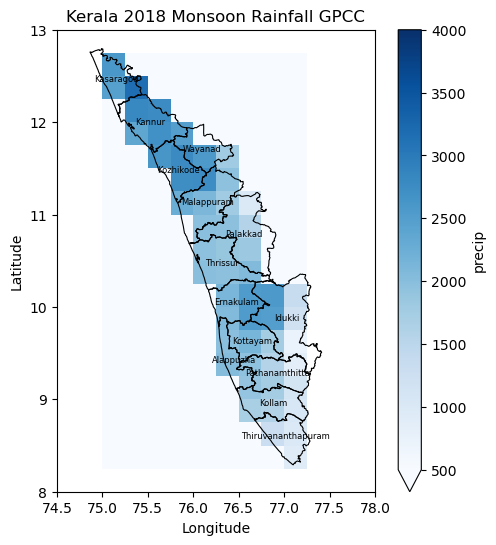

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
district_gdf.boundary.plot(ax =ax, color='black',linewidth=0.8 )
im = kerala_monsoon_precip.plot(ax=ax, cmap='Blues', vmin=500, vmax=4000)
# Add labels for each district
for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):
    ax.text(x, y, label, fontsize=6,color= 'black', ha='center', va='center')
ax.set_xlim([74.5, 78])  # Adjust the longitude range
ax.set_ylim([8, 13])   # Adjust the latitude range
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kerala 2018 Monsoon Rainfall GPCC')
plt.show()

In [19]:
kerala_precip_2018 = filtered_riods_2018['precip'].mean(dim=['x', 'y'], skipna=True)

In [27]:
kerala_precip_monthly_mean = kerala_mean_riods.mean(dim=['x', 'y'], skipna=True)

In [20]:
kerala_2018_pd = kerala_precip_2018.to_dataframe()

In [28]:
kerala_monthly_mean_pd = kerala_precip_monthly_mean.to_dataframe()

In [29]:
x_values = kerala_2018_pd.index
x_values = date2num(x_values)
y1_values =  kerala_2018_pd['precip']
y2_values = kerala_monthly_mean_pd['precip']
bar_width = 5.0

#### Plot Monthly Rainfall Data

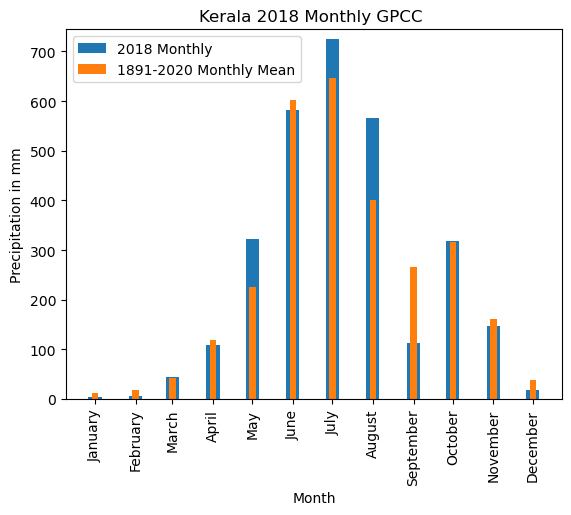

In [30]:
plt.bar(x_values, y1_values, width = 10.0, label = '2018 Monthly')
plt.bar(x_values, y2_values, width = bar_width, label = '1891-2020 Monthly Mean')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',  'August', 'September', 'October', 'November', 'December'] 

# Add labels and legend
plt.xlabel('Month')

plt.xticks(x_values, months, rotation=90)
# Set the y-axis to start from 0
plt.ylim(0, max(y1_values) + 20)

plt.ylabel('Precipitation in mm')
plt.title('Kerala 2018 Monthly GPCC ')
plt.legend()

# Show the plot
plt.show()